# Sample creation v2
This version uses multiple audio features to find a matching file

First we will do a pipeline for 1 thing. Then make the pipeline for all songs

## Pattern creation
This part of the code creates the patterns needed to lookup similairity

In [2]:
# Global sampling rate
sample_rate = 44100
std_stride = 0.5
noise_threshold = 0.2

In [3]:
output_folder_1 = 'samples_3'

In [4]:
import numpy as np
import librosa
import soundfile as sf
import os
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics import pairwise_distances
import random

In [5]:
# random.seed(64)

### Functions for getting features
These functions create the features needed for comparing against. Done in here so all files use the same pipeline

In [6]:
def array_to_feature_1(input_array:np.array)->np.array:
    """Function to convert numpy array to feature 1

    Args:
        input_array (np.array): Array to be converted

    Returns:
        np.array: mel spectogram
    """    

    feat_1 = librosa.feature.melspectrogram(y=input_array, sr= sample_rate)
    feat_1 = librosa.power_to_db(feat_1).astype(np.float32)

    # # feat_1 = librosa.stft(y=input_array)

    return feat_1

In [7]:
def array_to_feature_2(input_array:np.array)->np.array:
    """Function to convert numpy array to feature 2

    Args:
        input_array (np.array): Array to be converted

    Returns:
        np.array: mel spectogram
    """    

    # # feat_2 = librosa.feature.chroma_cens(y=input_array, sr= sample_rate)
    # # feat_2 = librosa.power_to_db(feat_2).astype(np.float32)

    feat_2 = librosa.feature.spectral_contrast(y=input_array, sr= sample_rate)

    # feat_2 = librosa.feature.mfcc(y=input_array, sr= sample_rate)




    return feat_2

In [8]:
def array_to_feature_3(input_array:np.array)->np.array:
    """Function to convert numpy array to feature 3
    Tried Spectral Bandwidth

    Args:
        input_array (np.array): Array to be converted

    Returns:
        np.array: mel spectogram
    """    

    feat_3 = librosa.feature.spectral_bandwidth(y=input_array, sr= sample_rate)
    # feat_3 = librosa.power_to_db(feat_3).astype(np.float32)

    return feat_3

### Create sample averages
This part of the code creates the patterns that the audio will be compared against

In [24]:
samples_folder = 'Inputs\Samples'
audio_files = []
for instrument_type in os.listdir(samples_folder):
    for file in os.listdir(os.path.join(samples_folder, instrument_type)):
        file_path = os.path.join(samples_folder, instrument_type, file)
        y= librosa.load(file_path, sr = sample_rate, mono=True)[0]
        audio_files.append(y)

# Calculate shortest audio length for window length 
audio_len = [len(file) for file in audio_files]
window_len = np.min(audio_len)

#Make sure sample is maximum of 1 second
window_len = min(window_len, sample_rate)

In [25]:
print('Window length: ', window_len)

Window length:  13385


In [26]:
def create_sample_info(samples_folder:str)->list:
    """Function for creating the info we need from each sample to detect the Samples

    Args:
        samples_folder (str): Folder which contains the sample type
        sample_rate (int, optional): sample_rate of output. Defaults to 44100.

    Returns:
        list: list with the following information: [length of the sample , Mel-spectogram pattern , chroma-cens pattern , Spectral-bandwidth pattern]
    """    

    #Get all audio files in sample folder
    audio_files = []

    files_list = os.listdir(samples_folder)

    for file in files_list:
        file_path = os.path.join(samples_folder, file)
        y= librosa.load(file_path, sr = sample_rate, mono=True)[0]
        audio_files.append(y)

    #Create_list of all features
    all_mel_spec = []
    all_chroma_cens = []
    all_spec_band = []

    for file in audio_files:
        file = file[:window_len]

        mel_spec = array_to_feature_1(file)
        all_mel_spec.append(mel_spec)

        chroma_cens = array_to_feature_2(file)
        all_chroma_cens.append(chroma_cens)
        
        spec_band = array_to_feature_3(file)
        all_spec_band.append(spec_band)

    #Calculate average for each feature and turn it into list
    average_melspec = np.mean(all_mel_spec, axis=0)
    average_chromacens = np.mean(all_chroma_cens, axis=0)
    average_specband = np.mean(all_spec_band, axis=0)



    sample_info_list = [window_len,average_melspec,average_chromacens,average_specband]

    return sample_info_list

In [27]:
sample_patterns = []

base_folder = os.getcwd()
samples_folder = os.path.join(base_folder, 'Inputs', 'Samples')
sample_types = os.listdir(samples_folder)

for sample_type in sample_types:
    sample_folder = os.path.join(samples_folder, sample_type)
    pattern = create_sample_info(sample_folder)
    sample_patterns.append(pattern)

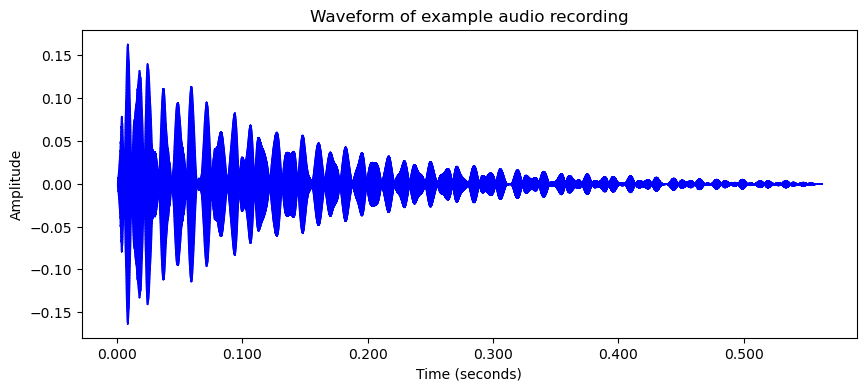

In [28]:
import librosa
from librosa.display import waveshow
import matplotlib.pyplot as plt

# Load the audio file
audio_path = os.path.join('Inputs', 'Samples', 'kick', 'kick2.wav')
waveform, sr = librosa.load(audio_path)

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=sr, color="blue")
plt.title('Waveform of example audio recording')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

## Sample creation

We now have lookup patterns for each type of sample. We now want to do a sliding window over the audio file with each pattern

In [29]:
def distance(window:np.array, compare_pattern:np.array):
    """_summary_

    Args:
        window (np.array): Current window extracted from sliding window function
        compare_pattern (np.array): Pattern the window has to be compared to

    Returns:
        cosine similairity of window and pattern
    """    

    #
    A = window.flatten().reshape(1, -1)
    B = compare_pattern.flatten().reshape(1, -1)


    #Cosine
    distance = cosine_distances(A,B)

    # # Euclidean
    # distance = euclidean_distances(A,B)

    # #Pearson
    # distance = pairwise_distances(A, B, metric='correlation')

    distance = distance[0][0]
    
    # distance = random.uniform(0,1)
    return distance


In [30]:
def sliding_window(input_array, compare_info:list, stride:float, threshold:float):
    """
    Create a sliding window over a 2D numpy array.

    Parameters:
    arr (numpy array): Input 1D numpy array of the audio file that needs to be compared
    window_size (float): Size of the sliding window samples. take from 1st index in sample_info
    compare_info (list): pattern that will be compared against with output of create_sample_info()
    stride (float): amount of the window_size to move when incorrect
    threshold (float): Threshold of combined cosine similairity between the three types needed to get a 'matching pattern'

    Returns:
    windows (list): List of numpy arrays representing the sliding windows that meet the requirement
    """
    window_size = compare_info[0]
    compare_melspec = compare_info[1]
    compare_chromacens = compare_info[2]
    compare_specband = compare_info[3]


    stride_step = int(stride*window_size)
    windows = []
    i = 0
    n_times = 0
    while i + window_size <= len(input_array):
        window = input_array[i:i+window_size]

        #Calculate how similair audio is to noise. If 1 it is noise Check if the highest noiselike window is over this threshold
        noise_like = np.max(librosa.feature.spectral_flatness(y=window))
        max_db = np.max(librosa.amplitude_to_db(window))
        if noise_like < noise_threshold:
        
            # calculate similairities
            mel_spec = array_to_feature_1(window)
            db = librosa.power_to_db(mel_spec)
            max_db = int(np.max(db))
            print(max_db)
            mel_cosine = distance(mel_spec, compare_melspec)


            chroma_cens = array_to_feature_2(window)
            chroma_cosine = distance(chroma_cens, compare_chromacens)

            spec_band = array_to_feature_3(window)
            specband_cosine = distance(spec_band, compare_specband)

            combined_similairity = mel_cosine + chroma_cosine + specband_cosine

            if combined_similairity < threshold and max_db > 8:
                    i += window_size
                    n_times += 1
                    windows.append(window)
            else:
                i += stride_step
                n_times += 1

        else:
            i += stride_step
            n_times += 1


    print(f'Used {n_times} windows to find {len(windows)} patterns')
    return windows

In [31]:
import concurrent.futures
def extract_samples(recordings_folder_path, output_samples_path):
    """Function for extracting samples from recordings and outputting the samples to output_samples_path

    Args:
        recordings_folder_path (_type_): Path to the files that will be checked for samples
        output_samples_path (_type_): Folder where the samples will be saved
    """    
    recordings = os.listdir(recordings_folder_path)

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            futures = []

            # Go over each recording in recordings
            for recording in recordings:
                print('starting recording: ', recording)
                input_path = os.path.join(recordings_folder_path, recording)
                audio_file = librosa.load(input_path, sr=sample_rate, mono=True)[0]

                #####Debug_code##### +- 9 seconden
                # audio_file = audio_file[100000:400000]
                ##########

                for i in range(len(sample_patterns)):
                    pattern = sample_patterns[i]
                    sample_name = sample_types[i]

                    # Submit the task to the executor, which will run it in a thread
                    future = executor.submit(
                        sliding_window, input_array=audio_file, compare_info=pattern,
                        stride=std_stride, threshold=2)

                    futures.append((future, sample_name, recording))


            # Wait for all tasks to complete and extract the results
            for future, sample_name, recording in futures:
                pattern_windows = future.result()

                # If there are samples, extract them
                if len(pattern_windows) > 0:
                    for i in range(len(pattern_windows)):
                        sample_window = pattern_windows[i]
                        file_name = f'{sample_name}_{i}_{recording}.wav'
                        out_path = os.path.join(output_samples_path, file_name)

                        # Write the sample to disk
                        sf.write(out_path, sample_window, sample_rate)

## Gridsearch for optimal threshold
Can be commented out in later version

In [15]:
def extract_samples_gridsearch(recordings_folder_path):
    """Function for extracting samples from recordings and outputting the samples to output_samples_path

    Args:
        recordings_folder_path (_type_): Path to the files that will be checked for samples
        output_samples_path (_type_): Folder where the samples will be saved
    """    
    recordings = os.listdir(recordings_folder_path)

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            futures = []

            # Go over each recording in recordings
            for recording in recordings:
                print('starting recording: ', recording)
                input_path = os.path.join(recordings_folder_path, recording)
                audio_file = librosa.load(input_path, sr=sample_rate, mono=True)[0]

                #####Debug_code##### +- 9 seconden
                # audio_file = audio_file[100000:400000]
                ##########

                for i in range(len(sample_patterns)):
                    pattern = sample_patterns[i]
                    sample_name = sample_types[i]

                    # Submit the task to the executor, which will run it in a thread
                    future = executor.submit(
                        sliding_window, input_array=audio_file, compare_info=pattern,
                        stride=std_stride, threshold=0.05)

                    futures.append((future, sample_name, recording))
            
            n_samples = 0
            # Wait for all tasks to complete and extract the results
            for future, sample_name, recording in futures:
                pattern_windows = future.result()

                # If there are samples, extract them
                if len(pattern_windows) > 0:
                     n_samples += 1
            return n_samples         

In [16]:
# test_measures = [0.05,0.1,0.15,0.2,0.25,0.3]
# recordings_path = os.path.join(base_folder, 'inputs', 'recordings')

# results = []

# for score_threshold in test_measures:
#     pattern_threshold_dict = {

#     'bass_1':score_threshold,
#     'bass_2':score_threshold,
#     'hi-hat_1':score_threshold,
#     'hi-hat_2':score_threshold,
#     'kick_1':score_threshold,
#     'kick_2':score_threshold,
#     'sfx_1':score_threshold,
#     'sfx_2':score_threshold,
#     'snare_1':score_threshold,
#     'snare_2':score_threshold,
#     'snare_3':score_threshold,
#     'crash_1':score_threshold}
    
#     results.append(extract_samples_gridsearch(recordings_path))
    

In [17]:
# print(results)

In [18]:
# # Threshold lookup table
# pattern_threshold_dict = {

#     'bass_1':0.15,
#     'bass_2':0.14,
#     'hi-hat_1':0.23,
#     'hi-hat_2':0.24,
#     'kick_1':0.18,
#     'kick_2':0.2,
#     'sfx_1':0.2,
#     'sfx_2':0.11,
#     'snare_1':0.15,
#     'snare_2':0.16,
#     'snare_3':0.22,
#     'crash_1':0.16
# }

In [32]:
recordings_path = os.path.join('Inputs', 'Recordings')
output_path = os.path.join(output_folder_1)

if not os.path.exists(output_path):
    os.makedirs(output_path)

extract_samples(recordings_path, output_path)

starting recording:  Amsterdammers_over_debat.wav
12
12
12
12
13
13
13
13
12
12
12
12
13
13
13
13
12
12
12
12
13
13
13
13
14
14
14
14
13
13
13
13
13
13
13
12
13
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
12
12
12
12
13
13
13
13
12
12
12
12
11
11
11
11
13
13
13
13
11
11
11
11
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
11
11
11
11
5
5
5
5
9
9
9
9
12
12
12
12
-100
-100
-100
-100
-100
-100
-100
-100
10
10
10
10
10
10
10
10
7
7
7
7
11
11
11
11
9
9
9
9
11
11
11
11
2
2
2
-100
2
-100
-100
9
-100
9
9
12
9
12
12
12
12
12
12
12
12
12
12
12
7
7
7
7
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
7
7
7
7
12
12
12
13
13
12
13
12
13
12
12
14
12
14
14
13
13
13
13
14
13
13
12
13
12
12
11
13
11
11
12
11
9
9
9
9
9
9
-100
9
9
1
-100
-100
-100
1
1
9
1
9
9
11
11
10
10
9
11
11
11
11
9
10
9
10
9
9
11
11
8
7
8
9
9
7
9
10
9
10
8
10
8
10
10
7
7
10
13
10
10
13
14
10
10
10
15
14
15
10
13
13
14
13
13
14
14
14
15
12
15
13
12
13
13
13
13
14
11
13
14
12
11
12
12
13
12
14
13
1